# Figure 6 - Supervised Clustering R-squared

In [13]:
import xgboost as xgb
import numpy as np
import shap
import matplotlib.pyplot as pl
import scipy.cluster
import pickle
import random

import xgboost
import sklearn.datasets
import shap

def plot_m(m, y, name="", color=""):
    m = np.nan_to_num(m)
    D = np.vstack([np.sum((m - m[i,:])**2, 1) for i in range(m.shape[0])])
    clust = scipy.cluster.hierarchy.complete(D)

    group_vals = [[y[i]] for i in range(m.shape[0])]
    for i in range(len(clust)):
        group_vals.append([])
        #print(clust[i,0], clust[i,1])
        group_vals[-1].extend(group_vals[int(clust[i,0])])
        group_vals[-1].extend(group_vals[int(clust[i,1])])

    count = m.shape[0]
    counts = [count]
    var = 1.0
    variances = [var]
    total_var = np.var(y)
    for i in range(m.shape[0], len(group_vals)):
        #print(np.var(group_vals[i]))
        count = count - 1
        counts.append(count)
        clust_ind = i-m.shape[0]
        ind1 = int(clust[clust_ind,0])
        ind2 = int(clust[clust_ind,1])
        var = var - np.var(group_vals[ind1])*len(group_vals[ind1])
        var = var - np.var(group_vals[ind2])*len(group_vals[ind2])
        var = var + np.var(group_vals[i])*(len(group_vals[ind1])+len(group_vals[ind2]))
        variances.append(1-(var/total_var)/m.shape[0])
    #print(variances)
    #print(np.mean(variances), m.shape[0])

    return pl.plot([x for x in counts], np.array(variances), color=color, linewidth=2, label=name+" (AUC = "+str(round(np.mean(variances),2))+")")

/Users/slund1/anaconda3/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:298: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


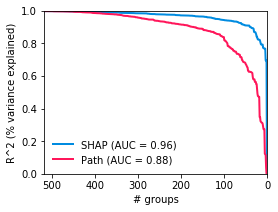

In [8]:
module_expression = np.loadtxt("data/module_expression.txt")
cf = lambda x: -1000 if x == b'NA' else x
neuropath = np.loadtxt("data/neuropath.txt", converters={i:cf for i in range(8)})

target = neuropath[:,1]
dtrain = xgb.DMatrix(module_expression, label=target)
dtrain = xgb.DMatrix(module_expression, label=target)
param = { "max_depth": 6, "base_score": np.mean(target), "eta": 0.01}
bst = xgb.train(param, dtrain, 300)
out = bst.predict(xgb.DMatrix(module_expression), pred_contribs=True)
out_path = bst.predict(xgb.DMatrix(module_expression), pred_contribs=True, approx_contribs=True)
out_pred = bst.predict(xgb.DMatrix(module_expression))

pl.close()
pl.rcParams["figure.figsize"] = (4,3)
plot_m(out, out_pred, "SHAP", color="#008BE0")
plot_m(out_path, out_pred, "Path", color="#ff165a")
#plot_m(module_expression, target, "Unsupervised", color="#18C45D")
pl.legend(loc="lower left", frameon=False, prop={'size':10})
pl.ylabel("R^2 (% variance explained)")
pl.xlabel("# groups")
pl.ylim(0,1)
pl.xlim(0,len(target))
pl.gca().invert_xaxis()
#pl.figsize(5,4)
#pl.figure(num=0, figsize=(4, 3))
#pl.savefig("alz2.pdf")
pl.show()

In [10]:
# load the data
raw_train_data = np.genfromtxt("data/adult.data", delimiter=",", dtype=None, autostrip=True, deletechars=["'"])
raw_test_data = np.genfromtxt("data/adult.test", delimiter=",", dtype=None, autostrip=True, deletechars=["'"], skip_header=1)

# extract the category options in the training data
col_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex", "capital-gain",
    "capital-loss", "hours-per-week", "native-country"
]
work_classes = list(set([v[col_names.index("workclass")] for v in raw_train_data]))
education_types = list(set([v[col_names.index("education")] for v in raw_train_data]))
marriage_statuses = list(set([v[col_names.index("marital-status")] for v in raw_train_data]))
occupations = list(set([v[col_names.index("occupation")] for v in raw_train_data]))
relationships = list(set([v[col_names.index("relationship")] for v in raw_train_data]))
races = list(set([v[col_names.index("race")] for v in raw_train_data]))
sexes = list(set([v[col_names.index("sex")] for v in raw_train_data]))
countries = list(set([v[col_names.index("native-country")] for v in raw_train_data]))
types = [work_classes, education_types, marriage_statuses, occupations, relationships, races, sexes, countries]
N = raw_train_data.shape[0]
P = sum(map(len, types)) + 5

def build_matrix(data, P):
    N = data.shape[0]
    X = np.zeros((N, P))
    
    group_names = []
    feature_groups = []
    
    
    def assign_class(i, offset, name, classes, data_col):
        if i == 0:
            group_names.append(name)
            feature_groups.append(list(range(offset, offset+len(classes))))
        j = classes.index(data[i][data_col])
        X[i,offset+j] = 1
        offset += len(classes)
        return offset
    
    def assign_num(i, offset, name, data_col):
        if i == 0:
            group_names.append(name)
            feature_groups.append([offset])
        X[i,offset] = data[i][data_col]
        offset += 1
        return offset
    
    for i in range(N):
        offset = 0
        offset = assign_num(i, offset, "Age", 0)
        offset = assign_class(i, offset, "Work class", work_classes, 1)
        offset = assign_class(i, offset, "Education", education_types, 3)
        offset = assign_num(i, offset, "Years in school", 4)
        offset = assign_class(i, offset, "Marital status", marriage_statuses, 5)
        offset = assign_class(i, offset, "Occupation", occupations, 6)
        offset = assign_class(i, offset, "Relationship", relationships, 7)
        offset = assign_class(i, offset, "Race", races, 8)
        offset = assign_class(i, offset, "Sex", sexes, 9)
        offset = assign_num(i, offset, "Capital gain", 10)
        offset = assign_num(i, offset, "Capital loss", 11)
        offset = assign_num(i, offset, "Weekly working hours", 12)
        offset = assign_class(i, offset, "Native country", countries, 13)
        
    y = np.array(list(v[-1] == b'>50K' for v in data))
    
    return X,y,group_names,feature_groups

def group_values(x):
    out = []
    offset = 0
    
    def add_class(offset, class_members):
        pos = -1
        try:
            pos = list(x[offset:offset+len(class_members)]).index(1)
        except:
            pass
        out.append("" if pos == -1 else class_members[pos])
        offset += len(class_members)
        return offset
    
    out.append(x[0])
    offset += 1
    offset = add_class(offset, work_classes)
    offset = add_class(offset, education_types)
    out.append(x[offset])
    offset += 1
    offset = add_class(offset, marriage_statuses)
    offset = add_class(offset, occupations)
    offset = add_class(offset, relationships)
    offset = add_class(offset, races)
    offset = add_class(offset, sexes)
    out.append(x[offset])
    offset += 1
    out.append(x[offset])
    offset += 1
    out.append(x[offset])
    offset += 1
    offset = add_class(offset, countries)
    
    return out

# build the training data
train_data,train_labels,group_names,feature_groups = build_matrix(raw_train_data, P)
data_median = shap.DenseData(np.reshape(np.median(train_data,0), (1,train_data.shape[1])), group_names, feature_groups)

# and test data
test_data,test_labels,group_names,feature_groups = build_matrix(raw_test_data, P)

In [14]:
inds = list(range(train_data.shape[0]))
random.shuffle(inds)

In [15]:
module_expression = train_data#np.loadtxt("data/module_expression.txt")
#cognitive_score = np.loadtxt("data/cognitive_score.txt")
#cf = lambda x: -1000 if x == b'NA' else x
#neuropath = np.loadtxt("data/neuropath.txt", converters={i:cf for i in range(8)})

cut_ind = 31000

target = train_labels#neuropath[:,label_ind]
module_expression_train = module_expression[inds[:cut_ind],:]
target_train = target[inds[:cut_ind]]
module_expression_test = module_expression[inds[cut_ind:],:]
target_test = target[inds[cut_ind:]]

dtrain = xgb.DMatrix(module_expression_train, label=target_train)
dtest = xgb.DMatrix(module_expression_test, label=target_test)
param = { "max_depth": 6, "base_score": np.mean(target_train), "eta": 0.1, "colsample_bytree": 0.1}
param = { "max_depth": 6, "base_score": np.mean(target_train), "eta": 0.1, "subsample": 0.5}
bst = xgb.train(param, dtrain, 200)
out = bst.predict(xgb.DMatrix(module_expression_test), pred_contribs=True)
out_path = bst.predict(xgb.DMatrix(module_expression_test), pred_contribs=True, approx_contribs=True)
pred = bst.predict(xgb.DMatrix(module_expression_test))

/Users/slund1/anaconda3/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:298: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


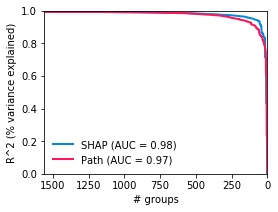

In [16]:
pl.close()
pl.rcParams["figure.figsize"] = (4,3)
plot_m(out, pred, "SHAP", color="#008BE0")
plot_m(out_path, pred, "Path", color="#ff165a")
#plot_m(module_expression_test_std, pred, "Unsupervised", color="#18C45D")
pl.legend(loc="lower left", frameon=False, prop={'size':10})
pl.ylabel("R^2 (% variance explained)")
pl.xlabel("# groups")
pl.ylim(0,1)
pl.xlim(0,len(target_test))
pl.gca().invert_xaxis()
#pl.figsize(5,4)
#pl.figure(num=0, figsize=(4, 3))
#pl.savefig("census_data2.pdf")
pl.show()